In [ ]:
import os
import cv2
import zipfile
from tqdm import tqdm
from io import BytesIO
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
from tensorflow.keras import regularizers

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving CK+48.zip to CK+48.zip


In [ ]:
zip_path = next(iter(uploaded))
with zipfile.ZipFile(BytesIO(uploaded[zip_path]), 'r') as zip_ref:
    zip_ref.extractall("/content/CK+48")
extracted_path = "/content/CK+48/CK+48"
os.listdir(extracted_path)
DATADIR = extracted_path
CATEGORIES = os.listdir(DATADIR)

In [ ]:
def load_data():
    data = []
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)

        for img in tqdm(os.listdir(path)):
            img_array = cv2.imread(os.path.join(path, img), 0)
            data.append([img_array, class_num])

    return data

In [ ]:
data = load_data()
len(data)

100%|██████████| 84/84 [00:00<00:00, 6012.21it/s]


981

In [ ]:
X = np.array([ x[0] for x in data])
y = np.array([Y[1] for Y in data])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True)
# reshaping y_train and y_test
y_train = np.reshape(y_train, (len(y_train),1))
y_test  = np.reshape(y_test , (len(y_test ),1))
X_train_Gabor  = X_train
X_test_Gabor = X_test
X_train = np.expand_dims(X_train, axis=3)
X_test = np.expand_dims(X_test, axis=3)
X_train = X_train / 255.0
X_test = X_test / 255.0
y_train_SVM = y_train
y_test_SVM = y_test
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
def Gabor_filter(K_size=111, Sigma=10, Gamma=1.2, Lambda=10, Psi=0, angle=0):
    # get half size
    d = K_size // 2

    # prepare kernel
    gabor = np.zeros((K_size, K_size), dtype=np.float32)

    # each value
    for y in range(K_size):
        for x in range(K_size):
            # distance from center
            px = x - d
            py = y - d

            # degree -> radian
            theta = angle / 180. * np.pi

            # get kernel x
            _x = np.cos(theta) * px + np.sin(theta) * py

            # get kernel y
            _y = -np.sin(theta) * px + np.cos(theta) * py

            # fill kernel
            gabor[y, x] = np.exp(-(_x**2 + Gamma**2 * _y**2) / (2 * Sigma**2)) * np.cos(2*np.pi*_x/Lambda + Psi)

    # kernel normalization
    gabor /= np.sum(np.abs(gabor))

    return gabor


# Use Gabor filter to act on the image
def Gabor_filtering(gray, K_size=111, Sigma=10, Gamma=1.2, Lambda=10, Psi=0, angle=0):
    # get shape
    H, W = gray.shape

    # padding
    gray = np.pad(gray, (K_size//2, K_size//2), 'edge')

    # prepare out image
    out = np.zeros((H, W), dtype=np.float32)

    # get gabor filter
    gabor = Gabor_filter(K_size=K_size, Sigma=Sigma, Gamma=Gamma, Lambda=Lambda, Psi=0, angle=angle)

    # filtering
    for y in range(H):
        for x in range(W):
            out[y, x] = np.sum(gray[y : y + K_size, x : x + K_size] * gabor)

    out = np.clip(out, 0, 255)
    out = out.astype(np.uint8)

    return out

# Use 6 Gabor filters with different angles to perform feature extraction on the image
def Gabor_process(img):
#     print(img.shape)
    # get shape
    H, W = img.shape

    # gray scale
#     gray = BGR2GRAY(img).astype(np.float32)

    # define angle
    #As = [0, 45, 90, 135]
    As = [0,30,60,90,120,150]

    # prepare pyplot
#     plt.subplots_adjust(left=0, right=1, top=1, bottom=0, hspace=0, wspace=0.2)

    out = np.zeros([H, W], dtype=np.float32)

    # each angle
    for i, A in enumerate(As):

        # gabor filtering
        _out = Gabor_filtering(img, K_size=11, Sigma=1.5, Gamma=1.2, Lambda=3, angle=A)


        # add gabor filtered image
        out += _out


    # scale normalization
    out = out /out.max()*255
    out = out.astype(np.uint8)

    return out

In [ ]:
def create_Gabor_features(data):
    Feature_data = np.zeros((len(data),48,48,1))

    for i in range(len(data)):
        img = data[i]
        out = Gabor_process(img)
        out = np.expand_dims(out , axis = 2) # adding color channel
        Feature_data[i] = out/255.00


    return Feature_data

In [ ]:
X_train.shape

(784, 48, 48, 1)

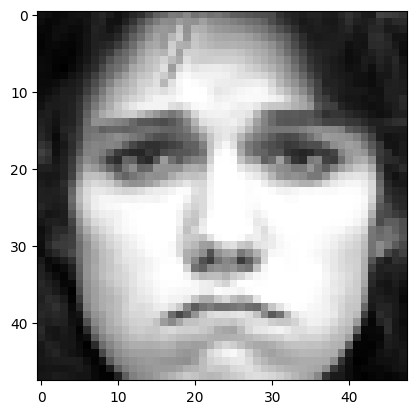

In [ ]:
plt.imshow(X_train_Gabor[0]/255.0, cmap ='gray')

In [ ]:
X_train_Gabor=create_Gabor_features(X_train_Gabor)
X_test_Gabor=create_Gabor_features(X_test_Gabor)

X_train_Gabor.shape , X_test_Gabor.shape

((784, 48, 48, 1), (197, 48, 48, 1))

(-0.5, 47.5, 47.5, -0.5)

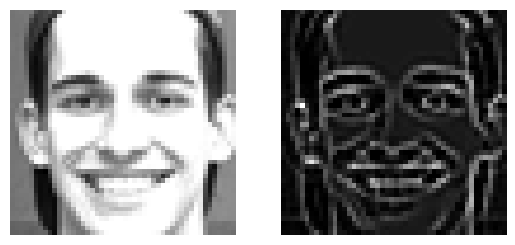

In [ ]:
sample = random.randint(100,500)
plt.subplot(1,2,1)
plt.imshow(X_train[sample],cmap='gray')
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(X_train_Gabor[sample],cmap='gray')
plt.axis("off")

In [ ]:
X_train_Gabor.shape

(784, 48, 48, 1)

In [ ]:
def create_model(input_shape=None):
    if input_shape is None :
        input_shape=(48,48,1)

    model = Sequential()
    model.add(Conv2D(6, (5, 5), input_shape=input_shape, padding='same', activation = 'relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Conv2D(16, (5, 5), padding='same', activation = 'relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation = 'relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(7, activation = 'softmax'))

    return model

es = EarlyStopping(
    monitor='val_accuracy', min_delta=0.0001, patience=10, verbose=2,
    mode='max', baseline=None, restore_best_weights=True
)
lr = ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.1, patience=5, verbose=2,
    mode='max', min_delta=1e-5, cooldown=0, min_lr=0
)

callbacks = [es, lr]

In [ ]:
Gabor_model = create_model()
Gabor_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam' )

In [ ]:
Gabor_history = Gabor_model.fit(X_train_Gabor, y_train, batch_size=8 , epochs=50, validation_data = (X_test_Gabor, y_test) ,callbacks = [callbacks])

Epoch 1/50
98/98 [==============================] - 5s 31ms/step - loss: 1.8513 - accuracy: 0.2691 - val_loss: 1.7473 - val_accuracy: 0.3655 - lr: 0.0010
Epoch 2/50
98/98 [==============================] - 3s 26ms/step - loss: 1.4120 - accuracy: 0.4987 - val_loss: 1.1560 - val_accuracy: 0.5736 - lr: 0.0010
Epoch 3/50
98/98 [==============================] - 2s 24ms/step - loss: 1.0003 - accuracy: 0.6454 - val_loss: 0.8838 - val_accuracy: 0.7208 - lr: 0.0010
Epoch 4/50
98/98 [==============================] - 2s 24ms/step - loss: 0.7596 - accuracy: 0.7181 - val_loss: 0.6546 - val_accuracy: 0.7970 - lr: 0.0010
Epoch 5/50
98/98 [==============================] - 4s 37ms/step - loss: 0.5806 - accuracy: 0.8036 - val_loss: 0.5268 - val_accuracy: 0.8071 - lr: 0.0010
Epoch 6/50
98/98 [==============================] - 3s 32ms/step - loss: 0.4735 - accuracy: 0.8367 - val_loss: 0.3830 - val_accuracy: 0.8528 - lr: 0.0010
Epoch 7/50
98/98 [==============================] - 3s 26ms/step - loss: 0.3

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix


In [ ]:
y_pred = np.argmax(Gabor_model.predict(X_test_Gabor), axis=1)
y_test_labels = np.argmax(y_test, axis=1)
classification_rep = classification_report(y_test_labels, y_pred)
print("Classification Report:\n", classification_rep)


7/7 [==============================] - 0s 35ms/step
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       1.00      1.00      1.00        16
           2       1.00      1.00      1.00        33
           3       1.00      0.97      0.99        38
           4       1.00      1.00      1.00        12
           5       1.00      1.00      1.00        51
           6       0.93      1.00      0.96        13

    accuracy                           0.99       197
   macro avg       0.99      1.00      0.99       197
weighted avg       1.00      0.99      0.99       197



In [ ]:
def plot_performance(history):
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')

    plt.legend()
    plt.grid()
    plt.title('train and val loss evolution')

    plt.subplot(2, 1, 2)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')

    plt.legend()
    plt.grid()
    plt.title('train and val accuracy')

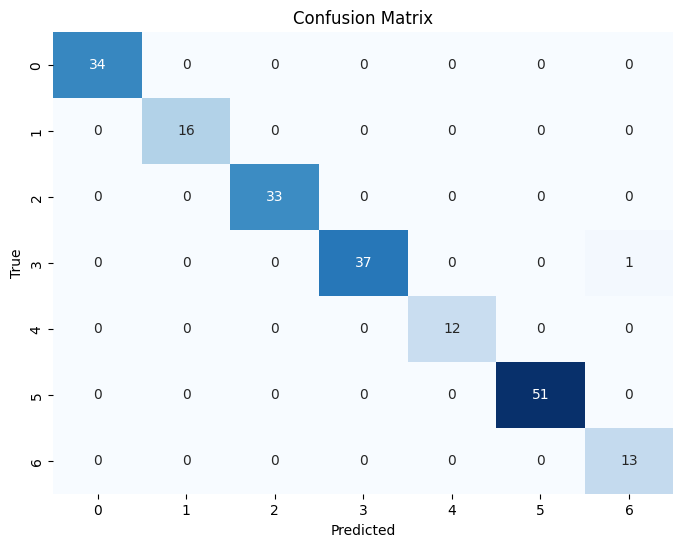

In [ ]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=np.unique(y_test_labels), yticklabels=np.unique(y_test_labels))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

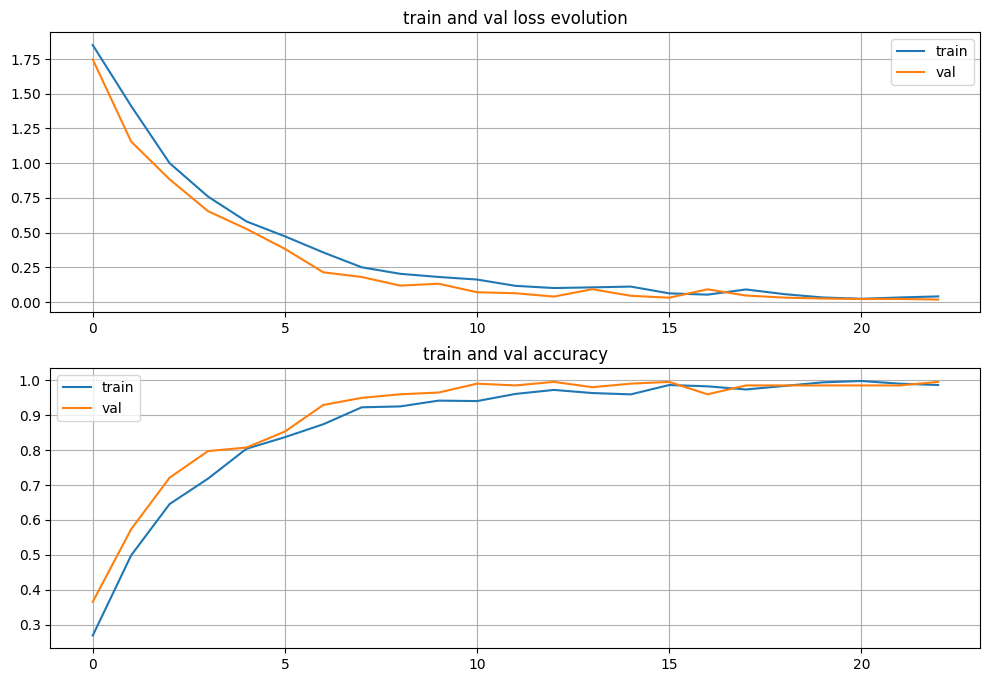

In [ ]:
plot_performance(Gabor_history)

In [ ]:
print("Gabor Accuracy :",Gabor_model.evaluate(X_test_Gabor, y_test, verbose = 0)[1])

Gabor Accuracy : 0.9949238300323486


In [ ]:
Gabor_model.save('Gabor_model.keras')